### Import Necessary Libraries

In [33]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
warnings.filterwarnings("ignore")

### Data Collection

In [4]:
path = r"alzheimer_new_2/Axial"

data = tf.keras.utils.image_dataset_from_directory(directory = path, image_size = (128, 128), batch_size = 10000)

Found 5154 files belonging to 3 classes.


In [5]:
class_names = data.class_names
print(class_names)

['AD', 'CI', 'CN']


In [7]:
label_map = {0: 'CN', 1:'CI', 2: 'AD'}
print(label_map)

{0: 'CN', 1: 'CI', 2: 'AD'}


In [6]:
for images, labels in data:
    X = images.numpy().astype("uint8")
    y = labels.numpy().astype("uint8")
    y=2-y
    
print(X.shape, y.shape)
print (y)

(5154, 128, 128, 3) (5154,)
[2 1 1 ... 1 1 0]


In [8]:
X_gray = np.zeros(shape = (*X.shape[:-1], 1))

for idx, img in enumerate(X):
    X_gray[idx] = tf.image.rgb_to_grayscale(img)

X = X_gray.copy()
print(X_gray.shape)

(5154, 128, 128, 1)


In [ ]:
label_counts = pd.Series(y).value_counts()
print(label_counts)

### Data Visualization

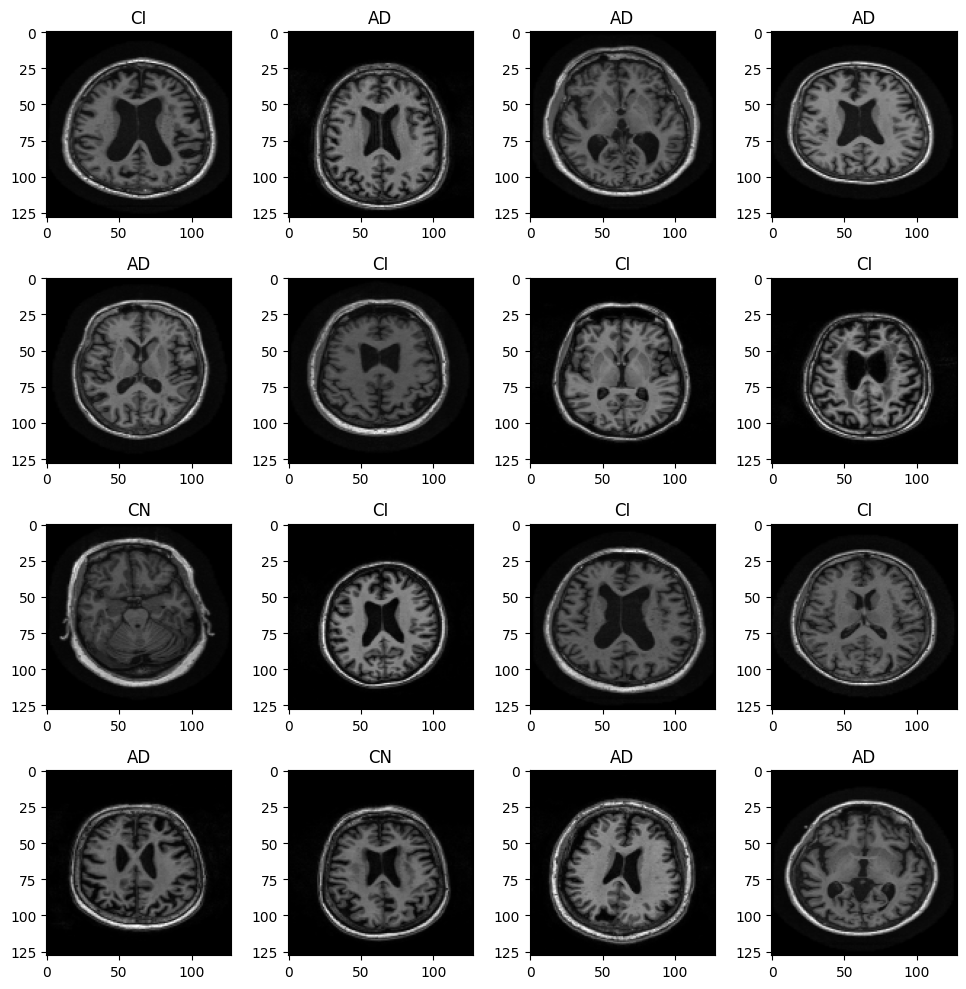

In [9]:
plt.figure(figsize = (10, 10))

for i in range(16):
    img = X[i]
    plt.subplot(4, 4, i + 1)
    plt.title(label_map[y[i]])
    plt.gray()
    plt.imshow(img)
    plt.tight_layout()
plt.show()

CI


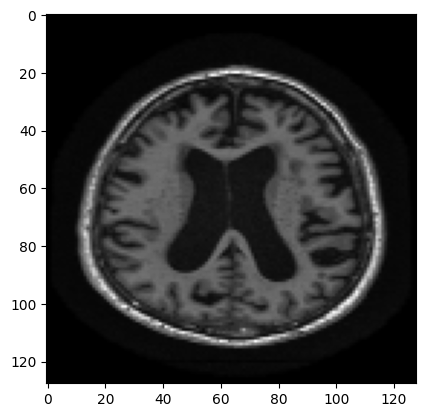

AD


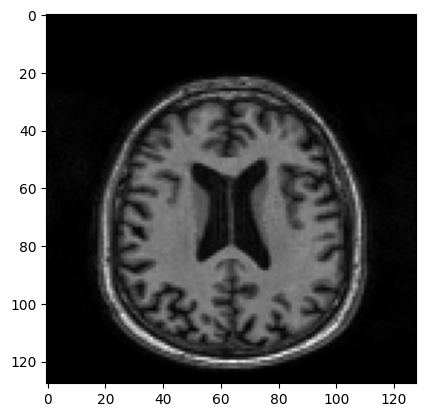

CN


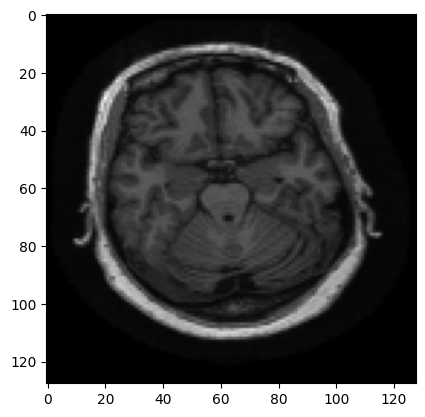

In [10]:
visited = set()

for img, label in zip(X_gray, y):
    if len(visited) == 3:
        break
    if label in visited:
        continue
    visited.add(label)
    print(label_map[label])
    plt.gray()
    plt.imshow(img)
    plt.show()

In [11]:
label_counts = pd.Series(y).value_counts()
print(label_counts)

1    2590
0    1440
2    1124
Name: count, dtype: int64


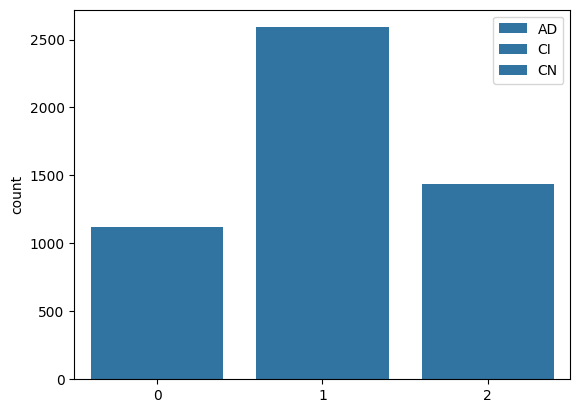

In [11]:
sns.countplot(x = y, label = label_map.values())
plt.legend()
plt.show()

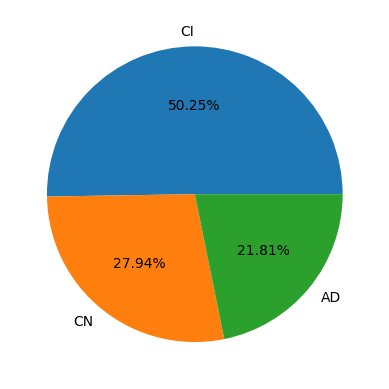

In [15]:
plt.pie(label_counts, autopct = "%.2f%%", labels = list(map(lambda key : label_map[key], label_counts.keys())))
plt.show()


### Data Augmentation

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal_and_vertical"),
])

In [12]:
X_new, y_new = [], []
max_total = 3000
X_0, X_1, X_2 = X[y == 0], X[y == 1], X[y == 2]

for label, X_set in zip(label_map.keys(), [X_0, X_1, X_2]):
    count = 0
    for img in X_set:
        if count > max_total - label_counts[label]:
            break
        for i in range(2):
            augmented_img = data_augmentation(img)
            X_new.append(augmented_img)
            y_new.append(label)
            count += 1
        
X_new, y_new = np.array(X_new), np.array(y_new)
print(X_new.shape, y_new.shape)

(3852, 128, 128, 1) (3852,)


In [13]:
X = np.concatenate([X, X_new])
y = np.concatenate([y, y_new])

print(X.shape, y.shape)

(9006, 128, 128, 1) (9006,)


In [14]:
print(pd.Series(y).value_counts())

2    3002
1    3002
0    3002
Name: count, dtype: int64


### Data Preprocessing and Preparation

In [15]:
#scaling
X = X / 255.0

print(X.min(), X.max())

0.0 0.9921568627450981


In [17]:
# Splitting the data into training, testing and validation sets

X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(X, y, test_size = 0.20, 
                                                                            random_state = 3, stratify = y)

X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_val, y_train_val, test_size = 0.20, 
                                                                  random_state = 3, stratify = y_train_val)

print(X_train.shape, X_val.shape, X_test.shape)

print(f"Total instances: {X.shape[0]}\nTrain instances: {X_train.shape[0]}   \
        \nValidation instances: {X_val.shape[0]}\nTest instances: {X_test.shape[0]}")

(5763, 128, 128, 1) (1441, 128, 128, 1) (1802, 128, 128, 1)
Total instances: 9006
Train instances: 5763           
Validation instances: 1441
Test instances: 1802


In [19]:
num_samples = X_train.shape[0]
X_train_reshaped = X_train.reshape(num_samples, -1)


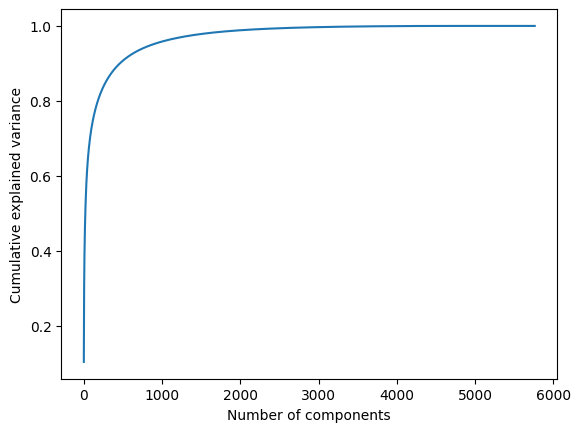

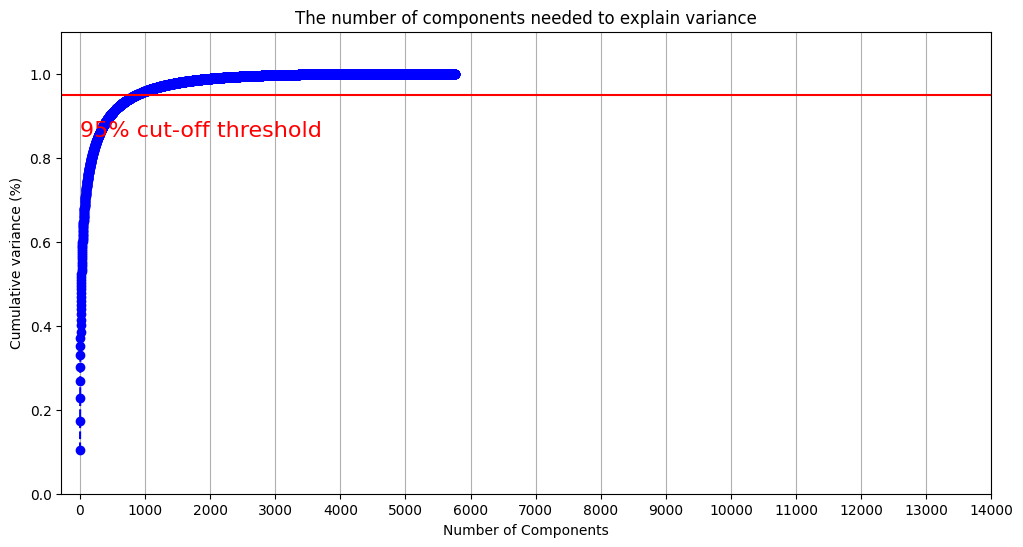

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_sc_train = scaler.fit_transform(X_train_reshaped)

pca = PCA()#add n_components=the feature at 95%
pca.fit(X_sc_train)
features_pca_train = pca.fit_transform(X_sc_train)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')



plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 5764, step = 1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 15000, step = 1000)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
ax.grid(axis='x')
plt.show()

In [24]:
n_components = 800
pca=PCA(n_components)
features_pca_train = pca.fit_transform(X_sc_train)
np.save('features_pca_train_normalized_NEWDATA.npy', features_pca_train)


NOT NEEDED

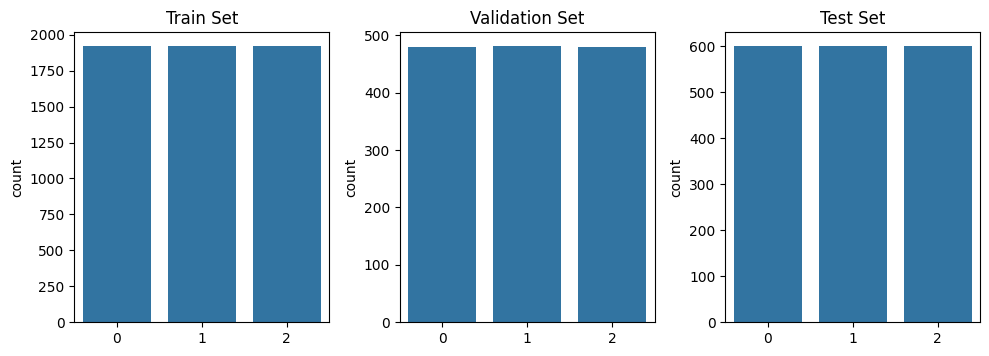

In [23]:
# Checking whether the classes are distributed uniformely among train, test and validation sets

plt.figure(figsize = (10, 10))

for i, labels, label_name in zip(range(3), [y_train, y_val, y_test], ["Train Set", "Validation Set", "Test Set"]):
    plt.subplot(3, 3, i + 1)
    plt.title(label_name)
    sns.countplot(x = labels)
    plt.tight_layout()
plt.show()

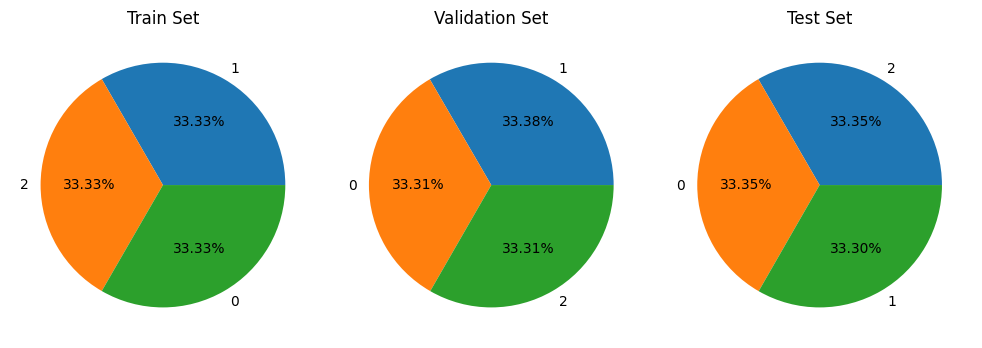

In [24]:
plt.figure(figsize = (10, 10))

for i, labels, label_name in zip(range(3), [y_train, y_val, y_test], ["Train Set", "Validation Set", "Test Set"]):
    plt.subplot(3, 3, i + 1)
    plt.title(label_name)
    label_counts = pd.Series(labels).value_counts()
    plt.pie(label_counts, autopct = "%.2f%%", labels = label_counts.keys())
    plt.tight_layout()
plt.show()

### Model Building and Training

In [ ]:
# Model building
input=Input(shape=(800,))
x = Dense(units=200, activation="relu")(input)
x=Dense(units=100, activation="relu")(x)
x=Dense(units=50, activation="relu")(x)
x=Dense(units=3, activation="softmax")(x)

model=Model(inputs=input,outputs=x)

In [36]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 200)            │       160,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,503 (724.62 KB)

 Trainable params: 185,503 (724.62 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
for idx, layer in enumerate(model.layers):
    print(f"Layer {idx}:", layer.name, layer.output_shape, layer.count_params())

AttributeError: 'Conv2D' object has no attribute 'output_shape'

In [53]:
model_arch = tf.keras.utils.plot_model(model, show_shapes = True)
model_arch

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [37]:
# Model compilation
model.compile(optimizer = "adam", loss='sparse_categorical_crossentropy', metrics = ["accuracy"])

In [38]:
X_train.shape

(5763, 128, 128, 1)

In [39]:
y_train.shape

(5763,)

In [40]:
features_pca_train.shape

(5763, 800)

In [73]:
num_classes = 3
y_train_one_hot = tf.one_hot(y_train, depth=num_classes)

In [41]:
#cb1 = tf.keras.callbacks.ModelCheckpoint("clf_model.keras", save_best_only = True)
#cb2 = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

history = model.fit(features_pca_train, y_train, epochs = 5)

Epoch 1/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6709 - loss: 1.0438
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9944 - loss: 0.0332
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0053
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.0021
Epoch 5/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 6/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 6.9258e-04
Epoch 7/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 4.8687e-04
Epoch 8/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 3.7895e-04
Epoch 9/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 2.8270e-04
Epoch 10/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 2.2048e-04
Epoch 11/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.8336e-04
Epoch 12/100
181/

In [75]:
result_df = pd.DataFrame(history.history)
result_df.head()

NameError: name 'history' is not defined

In [76]:
result_df.describe()

NameError: name 'result_df' is not defined

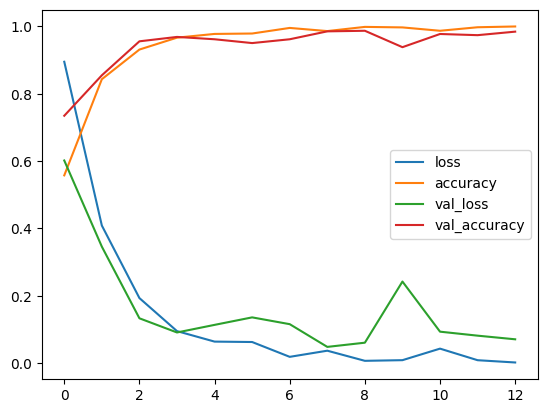

In [28]:
# Learning curves

result_df.plot()
plt.show()

In [42]:
# Evaluating the model on train set

loss, acc = model.evaluate(features_pca_train, y_train)

181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.6947e-09


: 

In [79]:
# Confusion Matrix

y_train_pred = model.predict(X_train)
y_train_pred_labels = np.array([np.argmax(y_) for y_ in y_train_pred])

cm = tf.math.confusion_matrix(labels = y_train, predictions = y_train_pred_labels)
print(cm)

181/181 ━━━━━━━━━━━━━━━━━━━━ 30s 163ms/step
tf.Tensor(
[[1921    0    0]
 [   0 1915    6]
 [   0    0 1921]], shape=(3, 3), dtype=int32)


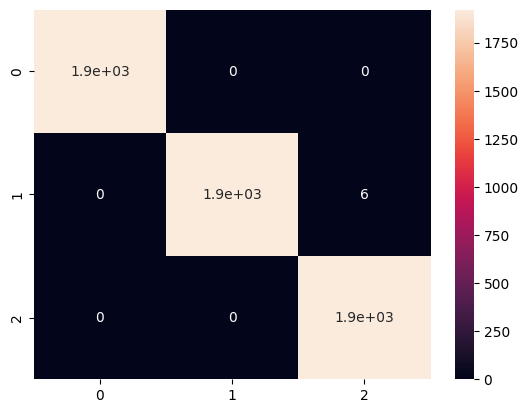

In [80]:
sns.heatmap(cm, annot = True)
plt.show()

In [81]:
tp_0, tn_0 = cm[0][0], cm[1][1] + cm[1][2] + cm[2][1] + cm[2][2]
fp_0, fn_0 = cm[1][0] + cm[2][0], cm[0][1] + cm[0][2]

tp_1, tn_1 = cm[1][1], cm[0][0] + cm[0][2] + cm[2][0] + cm[2][2]
fp_1, fn_1 = cm[0][1] + cm[2][1], cm[1][0] + cm[1][2]

tp_2, tn_2 = cm[2][2], cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]
fp_2, fn_2 = cm[0][2] + cm[1][2], cm[2][0] + cm[2][1]

def describeCM(tp, tn, fp, fn, i):
    print(f"\n\nClass {label_map[i]} : \n")
    print(f"True Positives : {tp}\nTrue Negatives : {tn}\nFalse Positives : {fp}\nFalse Negatives : {fn}")
    precision, recall = tp / (tp + fp), tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f"\nPrecision : {precision}\nRecall (Sensitivity) : {recall}\nF1-Score : {f1}")
    
describeCM(tp_0, tn_0, fp_0, fn_0, 0)
describeCM(tp_1, tn_1, fp_1, fn_1, 1)
describeCM(tp_2, tn_2, fp_2, fn_2, 2)



Class AD : 

True Positives : 1921
True Negatives : 3842
False Positives : 0
False Negatives : 0

Precision : 1.0
Recall (Sensitivity) : 1.0
F1-Score : 1.0


Class CI : 

True Positives : 1915
True Negatives : 3842
False Positives : 0
False Negatives : 6

Precision : 1.0
Recall (Sensitivity) : 0.9968766267568975
F1-Score : 0.9984358706986445


Class CN : 

True Positives : 1921
True Negatives : 3836
False Positives : 6
False Negatives : 0

Precision : 0.9968863518422418
Recall (Sensitivity) : 1.0
F1-Score : 0.9984407484407484


In [82]:
# Classification Report

clf_report = metrics.classification_report(y_train, y_train_pred_labels)
print(clf_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1921
           1       1.00      1.00      1.00      1921
           2       1.00      1.00      1.00      1921

    accuracy                           1.00      5763
   macro avg       1.00      1.00      1.00      5763
weighted avg       1.00      1.00      1.00      5763



### Model Validation

In [84]:
num_classes = 3
y_test_one_hot = tf.one_hot(y_test, depth=num_classes)

In [85]:
# Evaluating the model on test set

loss, acc = model.evaluate(X_test, y_test_one_hot)

57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.9821 - loss: 0.0844


57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step


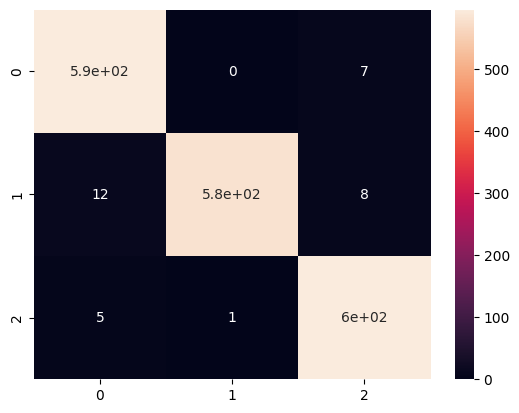

In [88]:
# Confusion Matrix

y_test_pred = model.predict(X_test)
y_test_pred_labels = np.array([np.argmax(y_) for y_ in y_test_pred])

cm = tf.math.confusion_matrix(labels = y_test, predictions = y_test_pred_labels)

sns.heatmap(cm, annot = True)
plt.show()

In [86]:
tp_0, tn_0 = cm[0][0], cm[1][1] + cm[1][2] + cm[2][1] + cm[2][2]
fp_0, fn_0 = cm[1][0] + cm[2][0], cm[0][1] + cm[0][2]

tp_1, tn_1 = cm[1][1], cm[0][0] + cm[0][2] + cm[2][0] + cm[2][2]
fp_1, fn_1 = cm[0][1] + cm[2][1], cm[1][0] + cm[1][2]

tp_2, tn_2 = cm[2][2], cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]
fp_2, fn_2 = cm[0][2] + cm[1][2], cm[2][0] + cm[2][1]

def describeCM(tp, tn, fp, fn, i):
    print(f"\n\nClass {label_map[i]} : \n")
    print(f"True Positives : {tp}\nTrue Negatives : {tn}\nFalse Positives : {fp}\nFalse Negatives : {fn}")
    precision, recall = tp / (tp + fp), tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f"\nPrecision : {precision}\nRecall (Sensitivity) : {recall}\nF1-Score : {f1}")
    
describeCM(tp_0, tn_0, fp_0, fn_0, 0)
describeCM(tp_1, tn_1, fp_1, fn_1, 1)
describeCM(tp_2, tn_2, fp_2, fn_2, 2)



Class AD : 

True Positives : 1921
True Negatives : 3842
False Positives : 0
False Negatives : 0

Precision : 1.0
Recall (Sensitivity) : 1.0
F1-Score : 1.0


Class CI : 

True Positives : 1915
True Negatives : 3842
False Positives : 0
False Negatives : 6

Precision : 1.0
Recall (Sensitivity) : 0.9968766267568975
F1-Score : 0.9984358706986445


Class CN : 

True Positives : 1921
True Negatives : 3836
False Positives : 6
False Negatives : 0

Precision : 0.9968863518422418
Recall (Sensitivity) : 1.0
F1-Score : 0.9984407484407484


In [89]:
# Classification Report

clf_report = metrics.classification_report(y_test, y_test_pred_labels)
print(clf_report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       601
           1       1.00      0.97      0.98       600
           2       0.98      0.99      0.98       601

    accuracy                           0.98      1802
   macro avg       0.98      0.98      0.98      1802
weighted avg       0.98      0.98      0.98      1802



### Saving the Model

In [38]:
model.save("clf_model_final.h5")